In [1]:

%gui qt
%matplotlib qt
import os.path as op

import numpy as np

import mne
from mne.datasets import sample



# To simulate the sample dataset, information of the sample subject needs to be
# loaded. 
data_path = sample.data_path()
subjects_dir = op.join(data_path, 'subjects')
subject = 'sample'
meg_path = op.join(data_path, 'MEG', subject)

# First, we get an info structure from the sample subject.
fname_info = op.join(meg_path, 'sample_audvis_raw.fif')
info = mne.io.read_info(fname_info)
tstep = 1 / info['sfreq']

# To simulate sources, we also need a source space. It can be obtained from the
# forward solution of the sample subject.
fwd_fname = op.join(meg_path, 'sample_audvis-meg-eeg-oct-6-fwd.fif')
fwd = mne.read_forward_solution(fwd_fname)
src = fwd['src']

    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
Reading forward solution from /Users/adebimpe/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    MEG and EEG forward solutions combined
    Source spaces transformed to the forward solution coordinate frame


In [2]:
# To simulate raw data, we need to define when the activity occurs using events
# matrix and specify the IDs of each event.
# Noise covariance matrix also needs to be defined.
# Here, both are loaded from the sample dataset, but they can also be specified
# by the user.

fname_event = op.join(meg_path, 'sample_audvis_raw-eve.fif')
fname_cov = op.join(meg_path, 'sample_audvis-cov.fif')

events = mne.read_events(fname_event)
noise_cov = mne.read_cov(fname_cov)



    366 x 366 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active


In [3]:
# Standard sample event IDs. These values will correspond to the third column
# in the events matrix.
event_id = {'HIPPO': 1}

###############################################################################
# In order to simulate source time courses, labels of desired active regions
# need to be specified for each of the 1 simulation conditions.
# Make a dictionary that maps conditions to activation strengths within
# aparc.a2009s [1]_ labels. In the aparc.a2009s parcellation:

# 
activations = {
    'HIPPO':
        [('G_oc-temp_med-Parahip-lh', 1)]          # label, activation (nAm)]
}

# https://www.sciencedirect.com/science/article/pii/S1053811910008542?via%3Dihub#sec1 for 
annot = 'aparc.a2009s'

# Load the 4 necessary label names.
label_names = sorted(set(activation[0]
                         for activation_list in activations.values()
                         for activation in activation_list))
region_names = list(activations.keys())

#  Define the time course of the activity for each region to activate. We use a
#  sine wave and it will be the same for all 4 regions.
source_time_series = np.sin(np.linspace(0, 1 * np.pi, 100)) * 10e-9




In [4]:
source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep)
for region_id, region_name in enumerate(region_names, 1):
    events_tmp = events[np.where(events[:, 2] == region_id)[0], :]
    for i in range(1):
        label_name = activations[region_name][i][0]
        label_tmp = mne.read_labels_from_annot(subject, annot,
                                               subjects_dir=subjects_dir,
                                               regexp=label_name,
                                               verbose=False)
        label_tmp = label_tmp[0]
        amplitude_tmp = activations[region_name][i][1]
        source_simulator.add_data(label_tmp,
                                  amplitude_tmp * source_time_series,
                                  events_tmp)

# To obtain a SourceEstimate object, we need to use `get_stc()` method of
# SourceSimulator class.
stc_data = source_simulator.get_stc()


In [5]:
#peak acvtivation at 48s
brain=stc_data.plot(subjects_dir=subjects_dir,initial_time=48,
                      hemi='split', views=['lat', 'med'])

Using control points [2.20310533e-09 6.66769001e-09 9.99874128e-09]


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
Setting up forward solutions
Computing gain matrix for transform #1/1
   Simulating data for forward operator 1/0
   Interval 0.000-1.665 sec
   Interval 1.665-3.330 sec
   Interval 3.330-4.995 sec
   Interval 4.995-6.660 sec
   Interval 6.660-8.325 sec
   Interval 8.325-9.990 sec
   Interval 9.990-11.655 sec
   Interval 11.655-13.320 sec
   Interval 13.320-14.985 sec
   Interval 14.985-16.650 sec
   Interval 16.650-18.315 sec
   Interval 18.315-19.980 sec
   Interval 19.980-21.644 sec
   Interval 21.644-23.309 sec
   Interval 23.309-24.974 sec
   Interval 24.974-26.639 sec
   Interval 26.639-28.304 sec
   Interval 28.304-29.969 sec
   Interval 29.969-31.634 sec
   Interval 31.634-33.299 sec
   Interval 33.299-34.964 sec
   Interval 34.964-36.629 sec
   Interval 36.629-38.294 sec
   Interval 38.294-39.959 sec
   Interval 39.959-41.624 sec
   Interval 41.624-43.289 sec
 

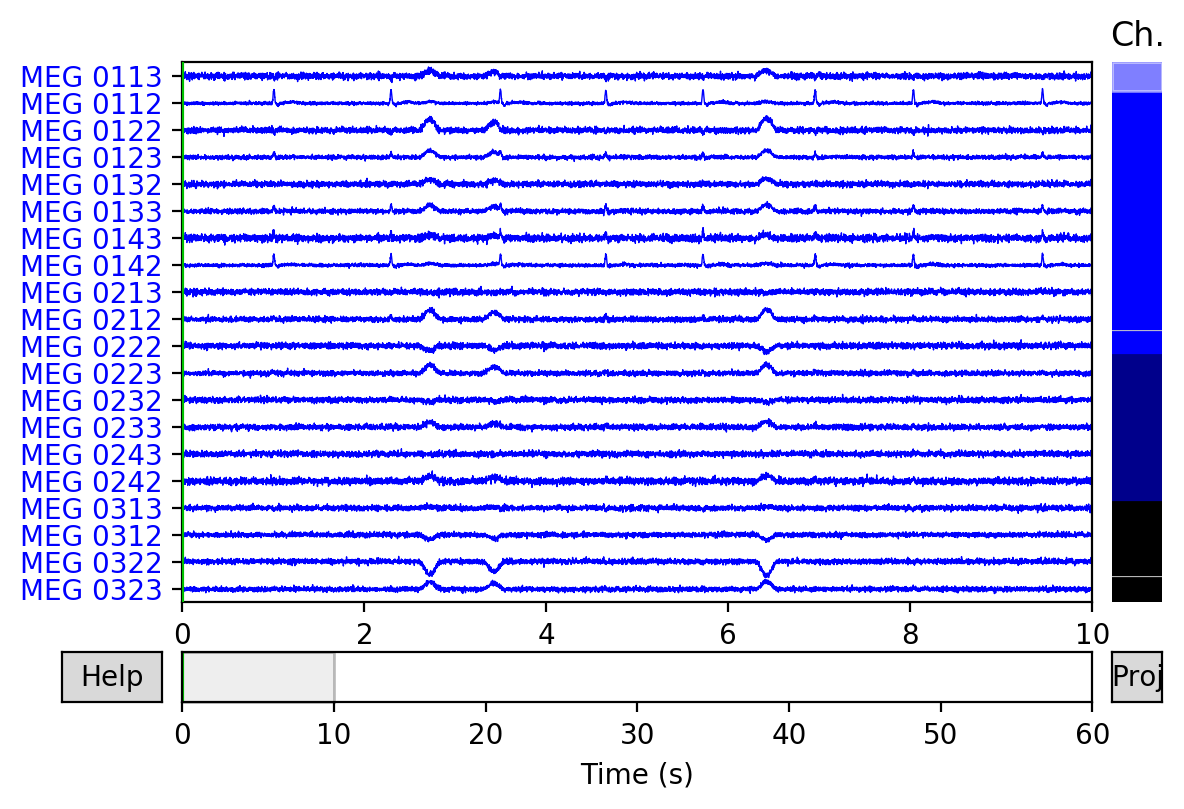

In [6]:
###############################################################################
# Simulate raw data

raw_sim = mne.simulation.simulate_raw(info, source_simulator, forward=fwd,
                                      cov=None)
raw_sim.set_eeg_reference(projection=True).crop(0, 60)  # for speed

mne.simulation.add_noise(raw_sim, cov=noise_cov, random_state=0)
mne.simulation.add_eog(raw_sim, random_state=0)
mne.simulation.add_ecg(raw_sim, random_state=0)

# Plot original and simulated raw data.
raw_sim.plot(title='Simulated raw data')


In [7]:
# Reconstruct simulated source time courses using dSPM inverse operator

method, lambda2 = 'dSPM', 1
epochs = mne.Epochs(raw_sim, events, event_id)
inv = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, noise_cov)
stc_diff = mne.minimum_norm.apply_inverse(
    epochs['HIPPO'].average(), inv, lambda2, method)

stc_diff2 = mne.minimum_norm.apply_inverse(
    epochs['HIPPO'].average(),inv)


brain = stc_diff.plot(subjects_dir=subjects_dir, initial_time=0.1,
                      hemi='split', views=['lat', 'med'],title='dSPM')

72 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 364 channels.
    364 out of 366 channels remain after picking
Selected 364 channels
Creating the depth weighting matrix...
    203 planar channels
    limit = 7262/7498 = 10.020865
    scale = 2.58122e-08 exp = 0.8
Applying loose dipole orientations. Loose value of 0.2.
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 4)
Computing data rank from covariance with rank=None
    Using tolerance 3.3e-13 (2.2e-16 eps * 305 dim * 4.8  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projector

In [8]:

method, lambda2 = 'eLORETA', 1.
epochs = mne.Epochs(raw_sim, events, event_id)
inv = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, noise_cov)
stc_aud = mne.minimum_norm.apply_inverse(
    epochs['HIPPO'].average(), inv, lambda2, method)

stc_diff = stc_aud

brain = stc_diff.plot(subjects_dir=subjects_dir, initial_time=0.1,
                      hemi='split', views=['lat', 'med'],title='eLORETA')


72 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 364 channels.
    364 out of 366 channels remain after picking
Selected 364 channels
Creating the depth weighting matrix...
    203 planar channels
    limit = 7262/7498 = 10.020865
    scale = 2.58122e-08 exp = 0.8
Applying loose dipole orientations. Loose value of 0.2.
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 4)
Computing data rank from covariance with rank=None
    Using tolerance 3.3e-13 (2.2e-16 eps * 305 dim * 4.8  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projector

In [9]:
method, lambda2 = 'sLORETA', 1
epochs = mne.Epochs(raw_sim, events, event_id)
inv = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, noise_cov)
stc_aud = mne.minimum_norm.apply_inverse(
    epochs['HIPPO'].average(), inv, lambda2, method)

stc_diff = stc_aud

brain = stc_diff.plot(subjects_dir=subjects_dir, initial_time=0.1,
                      hemi='split', views=['lat', 'med'],title='SLORETA')

72 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 364 channels.
    364 out of 366 channels remain after picking
Selected 364 channels
Creating the depth weighting matrix...
    203 planar channels
    limit = 7262/7498 = 10.020865
    scale = 2.58122e-08 exp = 0.8
Applying loose dipole orientations. Loose value of 0.2.
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 4)
Computing data rank from covariance with rank=None
    Using tolerance 3.3e-13 (2.2e-16 eps * 305 dim * 4.8  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projector